# From history time-range to metrics

This example shows how to make the prediction and evaluation of them given a time range. So it goes through the process of downloading the data from AWS to plotting the predictions and the metrics.

## Download the data

In [1]:
import nexradaws
from datetime import datetime
import os
import context
from mlnowcasting.predict import predict
from mlnowcasting.utils.metrics import metric_plots
from mlnowcasting.utils.plot_utils import plot_pred
from mlnowcasting.utils.utils import any2reflectivity
import numpy as np
import os
import imageio
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/s/chopin/a/grad/jcuomo/.conda/envs/gpu/lib/python3.7/site-packages/pyproj/__init__.py:73: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))
/s/chopin/a/grad/jcuomo/.local/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
/s/chopin/a/grad/jcuomo/.local/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION


/s/chopin/d/proj/jcuomo/699/repository


You can find more information and the list of available radars, as well as an alternative to download the data here: https://www.ncdc.noaa.gov/nexradinv/

Parameters to download the data from AWS:

In [2]:
event_name = '1'
radar = 'KFWS'                                 # from which radar 

save_dir_history   = "../data/events/" + event_name + "/history/" # where files are going to be downloaded
start_time_history = '20190407_172346'
end_time_history   = '20190407_182232'

save_dir_observation   = "../data/events/" + event_name + "/observation/" # where files are going to be downloaded
start_time_observation = '20190407_182630'
end_time_observation   = '20190407_192015'



In [3]:
def get_nexrad_files(radar, start_time, end_time, save_dir):
    conn = nexradaws.NexradAwsInterface()
    start = datetime.strptime(start_time, '%Y%m%d_%H%M%S')
    end   = datetime.strptime(end_time,   '%Y%m%d_%H%M%S')
    scans = conn.get_avail_scans_in_range(start, end, radar)
    localfiles = conn.download(scans, save_dir);
    # delete files finishing in _MDM
    for filename in os.listdir(save_dir):
        if '_MDM' in filename:
            os.remove(save_dir+'/'+filename) 

In [4]:
scans_history = get_nexrad_files(radar, start_time_history, end_time_history, save_dir_history);
scans_observation = get_nexrad_files(radar, start_time_observation, end_time_observation, save_dir_observation);

Downloaded KFWS20190407_172744_V06
Downloaded KFWS20190407_173914_V06
Downloaded KFWS20190407_173528_V06
Downloaded KFWS20190407_173142_V06
Downloaded KFWS20190407_172346_V06
Downloaded KFWS20190407_174259_V06
Downloaded KFWS20190407_175442_V06
Downloaded KFWS20190407_174644_V06
Downloaded KFWS20190407_175044_V06
Downloaded KFWS20190407_175840_V06
Downloaded KFWS20190407_175840_V06_MDM
Downloaded KFWS20190407_180238_V06
Downloaded KFWS20190407_180637_V06
Downloaded KFWS20190407_181435_V06
Downloaded KFWS20190407_181035_V06
Downloaded KFWS20190407_181834_V06
Downloaded KFWS20190407_182232_V06
17 out of 17 files downloaded...0 errors
Downloaded KFWS20190407_183759_V06
Downloaded KFWS20190407_183414_V06
Downloaded KFWS20190407_182630_V06
Downloaded KFWS20190407_183029_V06
Downloaded KFWS20190407_184501_V06
Downloaded KFWS20190407_184130_V06
Downloaded KFWS20190407_190609_V06
Downloaded KFWS20190407_190238_V06
Downloaded KFWS20190407_184833_V06
Downloaded KFWS20190407_185907_V06
Downloaded

## Convert ar2v (NexRad files) to numpy

In [5]:
def nexrad2cartesian(radar, size):
    '''
    Parameters:
        radar: from pyart.io.read_nexrad_archive() 
        size: tuple with desire image dimensions Height x Width
    Returns:
        numpy array with the reflectivity data in cartesian coordinates
        '''
##################### GRIDING CONFIGURATION ##############################################
# http://arm-doe.github.io/pyart-docs-travis/API/generated/pyart.map.grid_from_radars.html
    grids = pyart.map.grid_from_radars(                             #  convert to cartesian
        radar, 
        grid_shape = (1, size[0], size[1]),                          # define shape of frames (first dim is Z)
        grid_limits = ((radar.altitude['data'][0], 20000.0),         # z
                       (-150000, 150000),                            # y
                       (-150000, 150000)),                           # x
        fields=['reflectivity'],                                     # which data
        gridding_algo= 'map_gates_to_grid',                          # gridding algorithm
        weighting_function='BARNES2')                                # interpolation fx
    img_mtx = grids.fields['reflectivity']['data'][0,:,:]            # grab the reflectivity data (2D image)
    img_mtx = np.clip(img_mtx,0,70)                                  # truncate the dbz to lower and upper bounds to produce same colored images when normalizing 
    img_mtx = np.ma.filled(img_mtx, fill_value=0)                    # complate missing values with 0dBZ
    img_mtx = np.rint(img_mtx/70*255)                                # re-scale to 0-255
    img_mtx = img_mtx.astype('uint8')                                # use uint8 to be efficient
##########################################################################################
    return img_mtx

def nexrad2numpy(path, size=(64,64)):
    frames = 0
    for file in sorted(os.listdir(path)):  
        if file.endswith(('.png', '.npy', '.txt')): continue
        frames += 1
    print(frames, "radar files found")
    i = 0
    data   = np.zeros((1,frames,size[0],size[1]))
    titles = np.empty(frames, dtype=object)
    # iterate over the ar2v files: convert to cartesian and saved them as images
    for file in sorted(os.listdir(path)):  
        if file.endswith(('.png', '.npy', '.txt')): continue
        try:
            radar = pyart.io.read_nexrad_archive(path+'/'+file) # open the ar2v file
        except Exception as e:
            print(file," failed")
            print(e)
            continue
        data[0,i] = nexrad2cartesian(radar, size)
        titles[i] = file
        i += 1
    np.save(path+'dataset',data)
    np.save(path+'dataset_names',titles)
    
    return data,titles

Because the files downloaded from AWS do not have the extension .ar2v I cannot do an extension check (e.g. if not file.endswith('ar2v'): continue), so keep the folder with these files as clean as possible.

In [6]:
history, his_titles     = nexrad2numpy(save_dir_history)
observation, obs_titles = nexrad2numpy(save_dir_observation)

16 radar files found
16 radar files found


Notice, that they have 4 dimension. (events, frames, height, width). The 'events' allows to make several predictions at the same time.

In [7]:
history.shape,observation.shape

((1, 16, 64, 64), (1, 16, 64, 64))

## Make the prediction

In [8]:
model_name = 'convGRU_16_16'
prediction, _ = predict(history, model_name)
prediction.shape

=> loaded checkpoint 'convGRU_16_16.th' (trained for 300 epochs)


(1, 16, 64, 64)

## Compute the metrics

If there is more than 1 event (first dimension greater than 1) the metrics are an average.

Samples used: 1


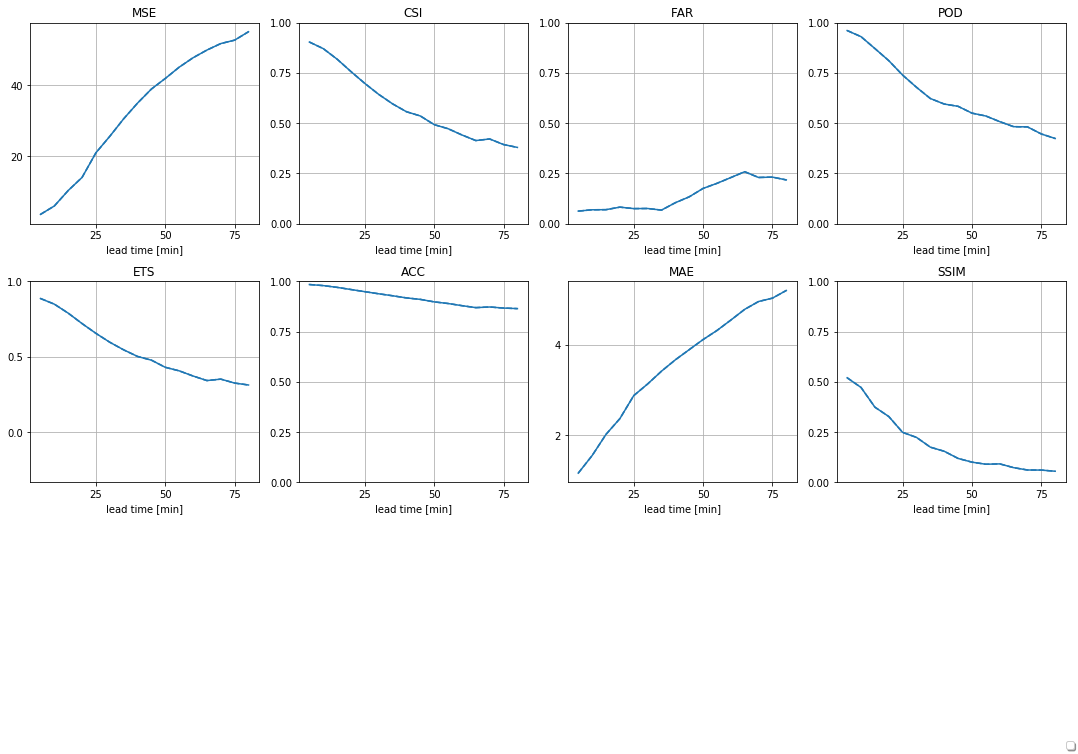

In [9]:
th_dbz = 20 # reflectivity threshold for computing the metrics
metric_table,fig = metric_plots(observation, prediction, th_dbz=th_dbz);  
fig

## Plot the predictions

Note that both 'history' and 'observation' are matrices of 8 bits, meaning that they go from 0 to 255.

That's the correct input range for the predict(history) function, and the output is in reflectivity units (dBZ). We need to convert the observation to reflectivity to match the prediction units for the plotting.


ALTERNATIVE (not done in this example):

We can concatenate history and observation (frame-wise), the model will know how many frames to use for the prediction based on the model parameters. And the function will return both prediction and observation in the same units.

hist_obs = np.concatenate((history, observation), axis=1)
prediction, observation = predict(hist_obs, model_name)


In [10]:
np.max(history), np.max(observation), np.max(prediction)

(203.0, 177.0, 40.149643)

In [11]:
observation = any2reflectivity(observation)
np.max(observation)

48.588234

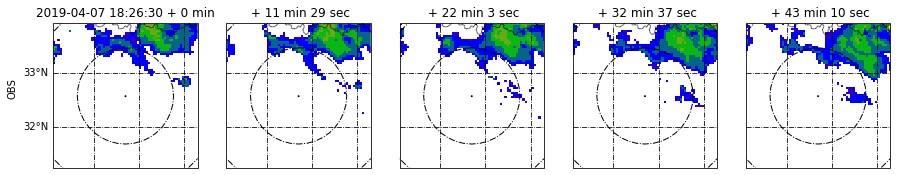

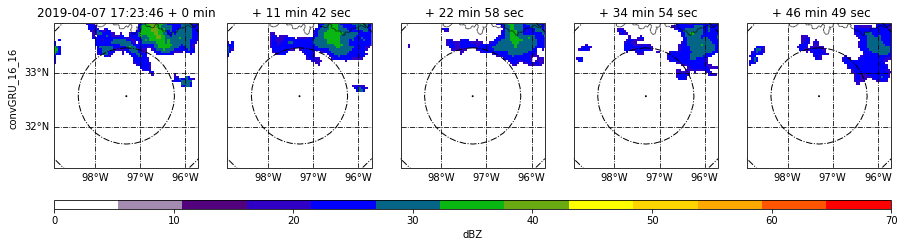

In [12]:
fig = plot_pred(observation[0], N_frames=5, cmap='darts', label='OBS', 
              title_files=obs_titles, plot_map=True, 
              plot_colorbar=False, bottom_label=False)

fig = plot_pred(prediction[0], N_frames=5, cmap='darts', label=model_name, 
              title_files=obs_titles, plot_map=True, 
              plot_colorbar=True, bottom_label=True)